In [57]:
import spacy
from sklearn.datasets import fetch_20newsgroups
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
nltk.download('punkt')
import gensim
from gensim.models import LdaModel
from gensim import models, corpora, similarities
import re
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import time
from nltk import entropy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
print('Success')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Success


In [3]:
twenty_train=fetch_20newsgroups(subset='train', shuffle=True, download_if_missing=True)
twenty_test=fetch_20newsgroups(subset='test', shuffle=True, download_if_missing=True)

In [19]:
twenty_train.data[0]
type(twenty_train)
text = [word for word in twenty_train.data]
text
print('Done')

Done


In [21]:
len(text)

11314

In [51]:
df=pd.DataFrame(data=doc,index=None, columns=['doc_no'])
df['data']=text
df.head()

,doc_no,data
0,doc0,From: lerxst@wam.umd.edu (where's my thing)\nS...
1,doc1,From: guykuo@carson.u.washington.edu (Guy Kuo)...
2,doc2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...
3,doc3,From: jgreen@amber (Joe Green)\nSubject: Re: W...
4,doc4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...


In [0]:
df['data'].dropna(inplace=True)
#doc['Content.'] = doc['Content.'].astype("|S")
df = df[df['data'].map(type)==str]

In [54]:
df = df.sample(frac=1.0)
df.reset_index(drop=True,inplace=True)
df.head()

,doc_no,data
0,doc1932,From: khiet@crystallizer.ecn.purdue.edu (Peter...
1,doc6199,From: jfare@53iss6.Waterloo.NCR.COM (Jim Fare)...
2,doc9675,From: bryanw@rahul.net (Bryan Woodworth)\nSubj...
3,doc8557,From: amanda@intercon.com (Amanda Walker)\nSub...
4,doc3481,From: noring@netcom.com (Jon Noring)\nSubject:...


In [68]:
def initial_clean(text):
    """
    Function to clean text of websites, email addresess and any punctuation
    We also lower case the text
    """
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower() # lower case the text
    text = nltk.word_tokenize(text)
    return text

nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['one', 'dont', 'get', 'edu', 'use'])
def remove_stop_words(text):
    """
    Function that removes all stopwords from text
    """
    return [word for word in text if word not in stop_words]

stemmer = PorterStemmer()
def stem_words(text):
    """
    Function to stem words, so plural and singular are treated the same
    """
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] # make sure we have no 1 letter words
    except IndexError: # the word "oed" broke this, so needed try except
        pass
    return text
    
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def word_lemmatizer(text):
  text=[lemmatizer.lemmatize(word) for word in text if len(word)>2]
  return text

def apply_all(text):
    """
    This function applies all the functions above into one
    """
    return word_lemmatizer(remove_stop_words(initial_clean(text))) #stemming removed currently

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [69]:
# clean text and title and create new column "tokenized"
t1 = time.time()
df['tokenized'] = df['data'].apply(apply_all)
t2 = time.time()
print("Time to clean and tokenize", len(df), "articles:", (t2-t1)/60, "min")

Time to clean and tokenize 11314 articles: 0.6572090983390808 min


In [70]:
df['tokenized']

0        [peter, thanh, khiet, vusubject, wanted, futon...
1        [jim, faresubject, ringing, earskeywords, ring...
2        [bryan, woodworthsubject, cview, answersorgani...
3        [amanda, walkersubject, secret, algorithm, cli...
4        [jon, noringsubject, need, reference, multiple...
                               ...                        
11309    [alexander, samuel, mcdiarmid, subject, driver...
11310    [gedaliah, friedenbergsubject, jewish, committ...
11311    [subject, trouble, compiling, sunosfrom, franc...
11312    [joe, hartleysubject, amiga, articleid, frippa...
11313    [david, buchholz, xsubject, looking, wmf, conv...
Name: tokenized, Length: 11314, dtype: object

In [71]:
# first get a list of all words
all_words = [word for item in list(df['tokenized']) for word in item]
# use nltk fdist to get a frequency distribution of all words
fdist = FreqDist(all_words)
len(fdist) # number of unique words

192844

In [83]:
k = 12000
top_k_words = fdist.most_common(k)
top_k_words[-10:]

[('exchanged', 11),
 ('problematic', 11),
 ('risky', 11),
 ('supplying', 11),
 ('stripping', 11),
 ('damphousse', 11),
 ('spotted', 11),
 ('lobo', 11),
 ('reception', 11),
 ('immortal', 11)]

In [0]:
top_k_words,_ = zip(*fdist.most_common(k))
top_k_words = set(top_k_words)
def keep_top_k_words(text):
    return [word for word in text if word in top_k_words]

In [86]:
df['tokenized'] = df['tokenized'].apply(keep_top_k_words)
df['tokenized']

0        [peter, wanted, wanted, purdue, university, en...
1        [jim, ringing, ringing, ear, sleep, jim, world...
2        [bryan, cview, answersorganization, networklin...
3        [amanda, walkersubject, secret, algorithm, cli...
4        [jon, need, reference, multiple, personality, ...
                               ...                        
11309    [alexander, samuel, subject, driver, organizat...
11310    [jewish, committee, middle, east, college, eng...
11311    [subject, trouble, compiling, francisco, compu...
11312    [joe, amiga, articleid, organization, technolo...
11313    [david, xsubject, looking, david, xorganizatio...
Name: tokenized, Length: 11314, dtype: object

In [87]:
# document length
df['doc_len'] = df['tokenized'].apply(lambda x: len(x))
doc_lengths = list(df['doc_len'])
df.drop(labels='doc_len', axis=1, inplace=True)

print("length of list:",len(doc_lengths),
      "\naverage document length", np.average(doc_lengths),
      "\nminimum document length", min(doc_lengths),
      "\nmaximum document length", max(doc_lengths))

length of list: 11314 
average document length 107.66077426197631 
minimum document length 2 
maximum document length 5290


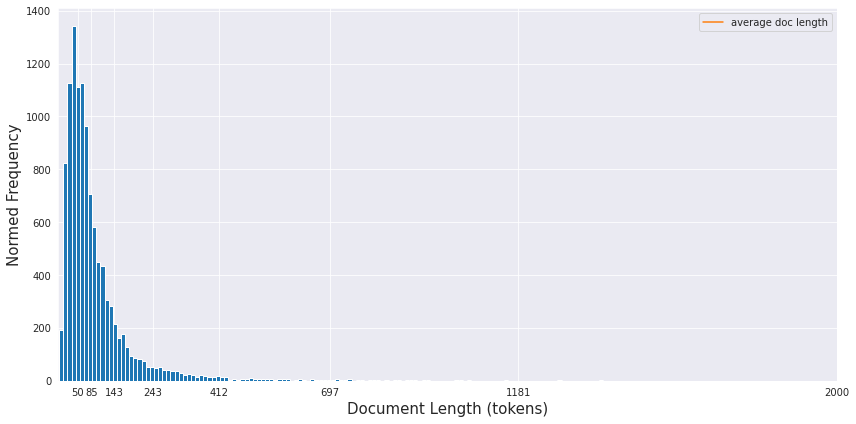

In [90]:
# plot a histogram of document length
num_bins = 500
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
n, bins, patches = ax.hist(doc_lengths, num_bins)
ax.set_xlabel('Document Length (tokens)', fontsize=15)
ax.set_ylabel('Normed Frequency', fontsize=15)
ax.grid()
ax.set_xticks(np.logspace(start=np.log10(50),stop=np.log10(2000),num=8, base=10.0))
plt.xlim(0,2000)
ax.plot([np.average(doc_lengths) for i in np.linspace(0.0,0.0035,100)], np.linspace(0.0,0.0035,100), '-',
        label='average doc length')
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

In [92]:
# only keep articles with more than 30 tokens, otherwise too short
df = df[df['tokenized'].map(len) >= 40]
# make sure all tokenized items are lists
df = df[df['tokenized'].map(type) == list]
df.reset_index(drop=True,inplace=True)
print("After cleaning and excluding short aticles, the dataframe now has:", len(df), "articles")

After cleaning and excluding short aticles, the dataframe now has: 8440 articles


In [0]:
# create a mask of binary values
msk = np.random.rand(len(df)) < 0.999

In [0]:
train_df = df[msk]
train_df.reset_index(drop=True,inplace=True)

test_df = df[~msk]
test_df.reset_index(drop=True,inplace=True)

In [97]:
print(len(df),len(train_df),len(test_df))

8440 8426 14


In [0]:
def train_lda(data):
    """
    This function trains the lda model
    We setup parameters like number of topics, the chunksize to use in Hoffman method
    We also do 2 passes of the data since this is a small dataset, so we want the distributions to stabilize
    """
    num_topics = 20
    chunksize = 300
    dictionary = corpora.Dictionary(df['tokenized'])
    corpus = [dictionary.doc2bow(doc) for doc in df['tokenized']]
    t1 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                   alpha=1e-2, eta=0.5e-2, chunksize=chunksize, minimum_probability=0.0, passes=2)
    t2 = time.time()
    print("Time to train LDA model on ", len(df), "articles: ", (t2-t1)/60, "min")
    return dictionary,corpus,lda

In [147]:
dictionary,corpus,lda = train_lda(train_df)

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


Time to train LDA model on  8440 articles:  0.455950395266215 min


In [148]:
lda.show_topics()

[(9,
  '0.041*"system" + 0.017*"support" + 0.016*"software" + 0.015*"number" + 0.014*"disk" + 0.014*"new" + 0.013*"computer" + 0.013*"available" + 0.013*"information" + 0.013*"also"'),
 (2,
  '0.156*"gun" + 0.051*"theyre" + 0.044*"called" + 0.031*"buy" + 0.030*"water" + 0.030*"building" + 0.030*"price" + 0.027*"purpose" + 0.023*"nature" + 0.022*"total"'),
 (5,
  '0.105*"god" + 0.043*"jesus" + 0.037*"christian" + 0.033*"jew" + 0.030*"people" + 0.028*"life" + 0.027*"bible" + 0.024*"believe" + 0.021*"death" + 0.021*"say"'),
 (10,
  '0.130*"drive" + 0.048*"hard" + 0.043*"disk" + 0.040*"car" + 0.029*"speed" + 0.027*"power" + 0.025*"high" + 0.023*"rate" + 0.021*"board" + 0.020*"steve"'),
 (3,
  '0.071*"space" + 0.061*"win" + 0.043*"mark" + 0.030*"launch" + 0.027*"contact" + 0.024*"pittsburgh" + 0.021*"bank" + 0.021*"hockey" + 0.019*"gordon" + 0.018*"soon"'),
 (7,
  '0.135*"law" + 0.098*"government" + 0.090*"right" + 0.069*"crime" + 0.053*"weapon" + 0.047*"people" + 0.042*"criminal" + 0.042*"

In [0]:
doc_freq=[]
for i in range(0,len(train_df)):
  bow = dictionary.doc2bow(train_df.iloc[i,2])
  doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=bow)])
  doc_freq.append(doc_distribution)
doc_freq
freq_max=np.argmax(doc_freq, axis=1)

In [168]:
freq_max[0:20]

array([ 9,  8,  2,  0,  0,  1,  9,  0,  9, 10,  8,  0,  8,  3,  8,  9,  0,
        3,  0, 10])

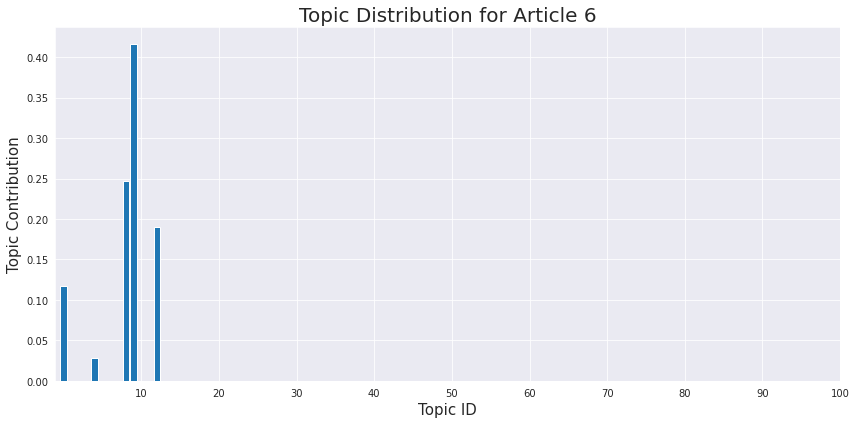

In [150]:
# bar plot of topic distribution for this document
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(doc_distribution)), doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for Article " + str(6), fontsize=20)
ax.set_xticks(np.linspace(10,100,10))
fig.tight_layout()
plt.show()

In [171]:
for i in doc_distribution.argsort()[0:][::-1]:
    print(i, lda.show_topic(topicid=i, topn=20), "\n")

0 [('would', 0.023124991), ('article', 0.019093985), ('know', 0.0166719), ('like', 0.015293267), ('think', 0.014082164), ('people', 0.011949832), ('say', 0.010429781), ('make', 0.01036815), ('writes', 0.009986338), ('time', 0.009424618), ('way', 0.009300718), ('thing', 0.00826305), ('something', 0.008194068), ('could', 0.008110541), ('even', 0.008076055), ('good', 0.0077776075), ('want', 0.0077521643), ('much', 0.0070436606), ('going', 0.0069957552), ('see', 0.006782064)] 

9 [('system', 0.040947475), ('support', 0.017057154), ('software', 0.015567796), ('number', 0.015453652), ('disk', 0.014439874), ('new', 0.014145182), ('computer', 0.013408331), ('available', 0.0131666), ('information', 0.013151851), ('also', 0.013067916), ('data', 0.012347245), ('feature', 0.012134551), ('communication', 0.011043444), ('access', 0.010913348), ('copy', 0.010715109), ('public', 0.010341465), ('service', 0.010145381), ('may', 0.010032348), ('technology', 0.009816054), ('university', 0.009169392)] 

4 

In [172]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=7, angle=.99, init='pca')# 13-D -> 2-D
tsne_lda = tsne_model.fit_transform(doc_freq) # doc_topic is document-topic matrix from LDA or GuidedLDA 

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8426 samples in 0.015s...
[t-SNE] Computed neighbors for 8426 samples in 1.132s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8426
[t-SNE] Computed conditional probabilities for sample 2000 / 8426
[t-SNE] Computed conditional probabilities for sample 3000 / 8426
[t-SNE] Computed conditional probabilities for sample 4000 / 8426
[t-SNE] Computed conditional probabilities for sample 5000 / 8426
[t-SNE] Computed conditional probabilities for sample 6000 / 8426
[t-SNE] Computed conditional probabilities for sample 7000 / 8426
[t-SNE] Computed conditional probabilities for sample 8000 / 8426
[t-SNE] Computed conditional probabilities for sample 8426 / 8426
[t-SNE] Mean sigma: 0.052617
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.496979
[t-SNE] KL divergence after 1000 iterations: 1.963188


In [183]:
topic_num = np.argmax(doc_freq,axis=1)
for i in range(0,len(topic_num)):
  if topic_num[i]>=10:
    topic_num[i]=9
topic_num[0:20]

array([9, 8, 2, 0, 0, 1, 9, 0, 9, 9, 8, 0, 8, 3, 8, 9, 0, 3, 0, 9])

In [184]:
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors
output_notebook()
n_topics = 20
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num],)
show(plot)

In [0]:
imUsingColab = False

if imUsingColab:
    !pip install gensim
    !pip install pyLDAvis
    !pip install vega
    !pip install altair

In [193]:
 !pip install pyLDAvis

     |████████████████████████████████| 1.6MB 2.6MB/s 
     |████████████████████████████████| 552kB 13.3MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=b5c7c15dc726a59e95c3868ead72faafc4e0e40f541c77481b87813d628d0337
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=01b35262ef035ab7aa37a333588a2c246c6da3db62f7822337a9070936d666a4
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [0]:
import gensim
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [195]:
pyLDAvis.gensim.prepare(lda, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.100670  0.202808       1        1  45.607731
8     -0.114730  0.136911       2        1  11.949610
9     -0.200386 -0.000431       3        1  11.267313
4     -0.188119 -0.088400       4        1   5.641269
10    -0.134332 -0.099910       5        1   4.278009
5      0.150117  0.231053       6        1   4.126372
11    -0.069841  0.096731       7        1   3.481991
1      0.212372  0.056162       8        1   3.078568
3      0.050355 -0.156666       9        1   3.039596
12    -0.071034 -0.109513      10        1   2.765339
7      0.292915  0.096919      11        1   1.840555
2     -0.031388 -0.053860      12        1   1.803362
6      0.204740 -0.311805      13        1   1.120285, topic_info=            Term          Freq         Total Category  logprob  loglift
1165       drive   6351.000000   6351.000000  Default  30.0000  30.0000
845       people   9127.000000   9127.000000  Default  29.0000  29.0000
151        right   5493.000000   5493.000000  Default  28.0000  28.0000
1450         god   4939.000000   4939.000000  Default  27.0000  27.0000
175        would  13060.000000  13060.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
1361  technology    667.438110   1930.858765  Topic13  -2.9535   3.4293
1552      murder    296.219025    593.421265  Topic13  -3.7658   3.7968
136     national    254.385742   1633.719604  Topic13  -3.9181   2.6318
469   background    132.936050    474.203125  Topic13  -4.5670   3.2198
329        today    109.092216   1608.922607  Topic13  -4.7647   1.8005

[669 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
415       7  1.000152   ability
416      10  0.999173  absolute
420       3  1.000249    access
251       1  0.200420       act
251       6  0.280797       act
...     ...       ...       ...
179       2  0.963203      year
179       8  0.036762      year
1562      1  0.999905       yes
180       1  0.993270     youre
180      12  0.006740     youre

[1120 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 9, 10, 5, 11, 6, 12, 2, 4, 13, 8, 3, 7])